In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [3]:
# Dataset description
mnist.DESCR

# Input data usually in 2D Numpy Array
mnist.data

# Label usually as ID Numpy array
mnist.target

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [4]:
x, y = mnist.data, mnist.target
x.shape


(70000, 784)

In [4]:
y.shape

(70000,)

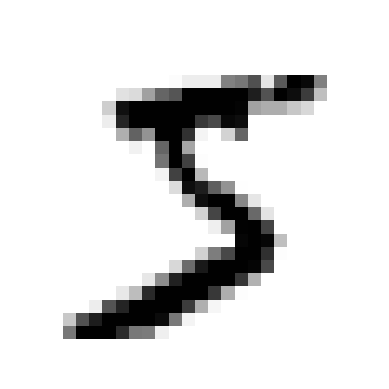

In [5]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis("off")
    
some_image = x[0]
plot_digit(some_image)
plt.show()

In [52]:
y[0]

'5'

In [53]:
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]


# Training a Binary Classifier

In [54]:
y_train_5 = (y_train == '5') # True for all 5's, False for all other digits
y_test_5 = (y_test == '5')

In [55]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_5)

KeyboardInterrupt: 

In [ ]:
sgd_clf.predict([some_image])

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(x_train, y_train_5)
print(any(dummy_clf.predict(x_train))) # Prints False: no 5s detected

False


In [ ]:
cross_val_score(dummy_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

In [ ]:
"""
NOTE:
IMPLEMENTING CROSS-VALIDATION
"""

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3) # Add shuffle=True if the dataset is not already shuffled 

for train_index, test_index in skfolds.split(x_train, y_train_5):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train[train_index]
    y_train_folds = y_train_5[train_index]
    x_test_folds = x_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct/ len(y_pred)) # prints 0.95035, 0.96035, 0.9604

0.95035
0.96035
0.9604


### Confusion Matrices(CM)

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)
conf_matrix = confusion_matrix(y_train_5, y_train_pred)
conf_matrix

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [ ]:
    """A Perfect classifier would have a only True Positives and True negatives.
    Lets pretend we have reached a perfection,
    """
    
    y_train_perfect_predictions = y_train_5 # Pretend we reached perfection
    confusion_matrix(y_train_perfect_predictions, y_train_5) 

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Precision, Recall and f1_score

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_score(y_train_5, y_train_pred) # == 3530/(687+3530)
recall_score(y_train_5, y_train_pred) # == 3530/(1891+3530)
f1_score(y_train_5, y_train_pred) # |

0.7325171197343847

### The Precision/Recall Trade-off

In [ ]:
"""Increasing Precision reduces Recall,  and Vice Versa.
    """
y_scores = sgd_clf.decision_function([some_image])
print(y_scores)  # Output: [2164.22030239]

#threshold = 0
threshold = 3000
y_some_image_pred = (y_scores > threshold)
print(y_some_image_pred)  # Output: [True]


[2164.22030239]
[False]


In [ ]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3,
method="decision_function")

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

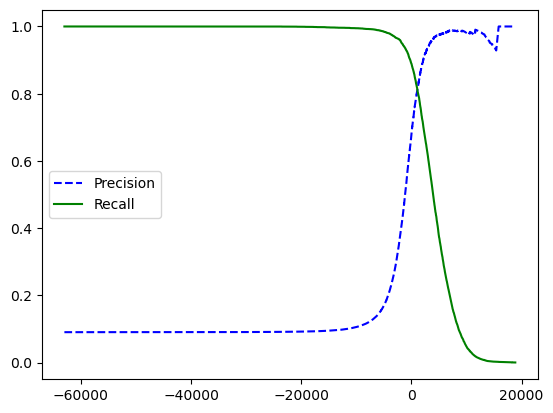

In [ ]:
from sklearn.metrics import precision_recall_curve

y_scores = sgd_clf.decision_function(x_train)
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# Plot precision vs. recall
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.legend()
plt.show()


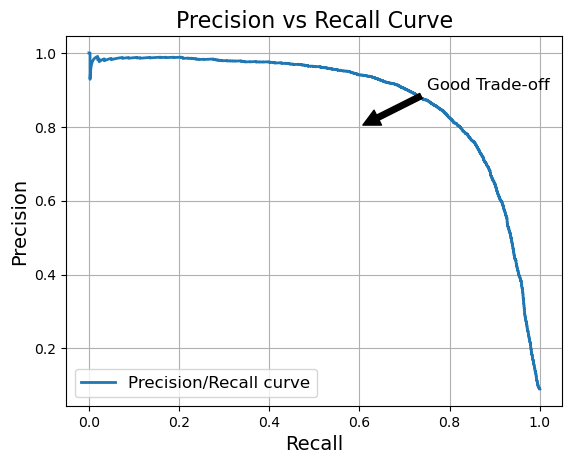

In [ ]:
import matplotlib.pyplot as plt

# Plot the Precision-Recall curve
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# Beautify the figure
plt.xlabel("Recall", fontsize=14)  # Label for the x-axis
plt.ylabel("Precision", fontsize=14)  # Label for the y-axis
plt.title("Precision vs Recall Curve", fontsize=16)  # Add a title
plt.grid(True)  # Add a grid
plt.legend(loc="best", fontsize=12)  # Add a legend

# Adding annotations or arrows
plt.annotate(
    'Good Trade-off', 
    xy=(0.6, 0.8),  # Example coordinates where a good trade-off might occur
    xytext=(0.75, 0.9), 
    arrowprops=dict(facecolor='black', shrink=0.05),
    fontsize=12
)

# Display the plot
plt.show()

In [ ]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

2123.562046995017

In [63]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.9000705384434516


0.7061427780852241

### The receiver operating characteristics (ROC) Curve

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

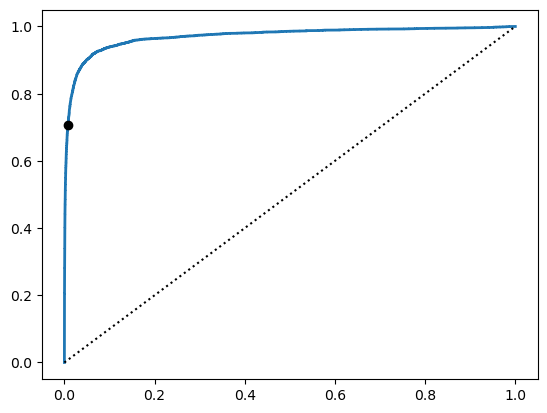

In [ ]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9709618248430906

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=4, method='predict_proba')

In [ ]:
y_probas_forest[:2]

array([[0.17, 0.83],
       [0.99, 0.01]])

In [ ]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

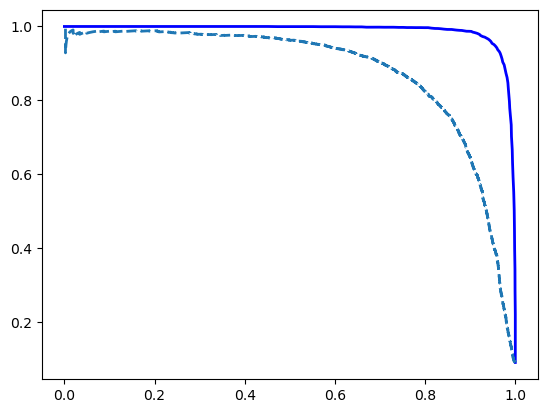

In [ ]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
 # beautify the figure: add labels, grid, and legend
plt.show()


In [57]:
y_train_pred_forest = y_scores_forest >= 0.5
print(f1_score(y_train_5, y_train_pred_forest))
print(roc_auc_score(y_train_5, y_scores_forest))

0.9323058915333593
0.9984268710591231


In [62]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5
print(f1_score(y_train_5, y_train_pred_forest))
print(roc_auc_score(y_train_5, y_scores_forest))

0.9323058915333593
0.9984268710591231
